<a href="https://colab.research.google.com/github/AquaSpare/deep_learning_assignment_3/blob/main/MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pandas.core.common import flatten
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Define hyperparameters
learning_rate = 0.06
batch_size = 36
num_epochs = 10
momentum = 0.9

In [ ]:
# Load the test and training data
train_dataset = datasets.MNIST('data', train=True, transform=transforms.ToTensor(), download=True)
train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST('data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Set the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

A few different models

In [ ]:
# Model with a single layer
model1 = nn.Sequential(
    nn.Linear(28 * 28, 10)
)

# Move the model to the GPU
model = model1.to(device)

In [ ]:
# Model with two layers, 200 hidden units
model2 = nn.Sequential(
    nn.Linear(28 * 28, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

# Move the model to the GPU
model = model2.to(device)

In [ ]:
# A basic convolutional network, exercise 1.2
class CNN_1(nn.Module):
  def __init__(self):
    super(CNN_1, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.fc1 = nn.Linear(32*7*7, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)

    return x

model = CNN_1().to(device)

In [ ]:
# A basic convolutional network, exercise 1.3
class CNN_2(nn.Module):
  def __init__(self):
    super(CNN_2, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.fc1 = nn.Linear(32*7*7, 10)

  def forward(self, x):
    x = self.pool(self.conv1(x))
    x = F.relu(x)
    x = self.pool(self.conv2(x))
    x = F.relu(x)
    x = F.relu(self.conv3(x))
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)

    return x

model = CNN_2().to(device)

In [ ]:
# A basic convolutional network, exercise 1.5 using tanh
class CNN_3(nn.Module):
  def __init__(self):
    super(CNN_3, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
    self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
    self.fc1 = nn.Linear(32*7*7, 10)

  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = self.pool(x)
    x = F.tanh(self.conv2(x))
    x = self.pool(x)
    x = F.tanh(self.conv3(x))
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)

    return x

model = CNN_3().to(device)

In [ ]:
# Method that counts the number of parameters of a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

21578


Defining the optimizer and loss

In [ ]:
# Define the loss and the optimizer, stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
loss = nn.CrossEntropyLoss()

In [ ]:
# Define the loss and the optimizer, ADAM, exercise 1.4
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss = nn.CrossEntropyLoss()

In [ ]:
# Define the loss and the optimizer, stochastic gradient descent with momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)
loss = nn.CrossEntropyLoss()

In [ ]:
# Define the loss and the optimizer, stochastic gradient descent with nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum, nesterov=True)
loss = nn.CrossEntropyLoss()

Training and testing related functions

In [ ]:
# function to evaluate accuracy on a given dataset in a loader
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      # x = x.reshape(x.shape[0], -1)

      scores = model(x)

      _, predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

    model.train()
    accuracy = num_correct/num_samples
  return accuracy

In [ ]:
# Train the network
cost_train = []
accuracy = []

for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_loader):
    # Get data to cuda() if possible
    data = data.to(device)
    targets = targets.to(device)

    # Reshape data to correct shape
    # data = data.reshape(data.shape[0], -1)

    # Forward
    scores = model(data)
    J = loss(scores, targets)

    # Backward
    optimizer.zero_grad()
    J.backward()

    # gradient descent step
    optimizer.step()

    cost_train.append(J.item())
    
  acc = check_accuracy(val_loader, model)
  accuracy.append(acc)

  print(f'Epoch {epoch+1} validation accuarcy {float(acc)*100:.2f}%')


Epoch 1 validation accuarcy 97.04%
Epoch 2 validation accuarcy 97.70%
Epoch 3 validation accuarcy 98.48%
Epoch 4 validation accuarcy 98.70%
Epoch 5 validation accuarcy 98.96%
Epoch 6 validation accuarcy 98.48%
Epoch 7 validation accuarcy 98.36%
Epoch 8 validation accuarcy 98.88%
Epoch 9 validation accuarcy 98.82%
Epoch 10 validation accuarcy 98.72%


Section for plots

In [ ]:
# Producing the confusion matrix

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

model.eval()
conf_matrix = np.zeros((10,10))
with torch.no_grad():
  for x, y in test_loader:
    scores = model(x)
    _, predictions = scores.max(1)
    conf_matrix += confusion_matrix(y.view(-1), predictions.view(-1), labels=[0,1,2,3,4,5,6,7,8,9])

    
    if (predictions != y).sum() > 0:
      x_fail = x
      y_fail = y
      break

model.train()
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

x_fail = x_fail.numpy()
y_fail = y_fail.numpy()
pred = predictions.numpy()

Actual value: [6]
Predicted value: [5]


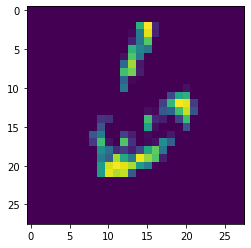

In [ ]:
plt.imshow(x_fail[0][0])
print(f'Actual value: {y_fail}')
print(f'Predicted value: {pred}')
plt.savefig('Missclassification_3')

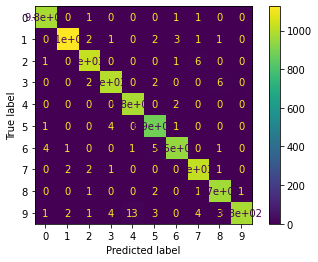

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp = disp.plot()
plt.savefig('Confusion_CNET1_ADAM')
plt.show()

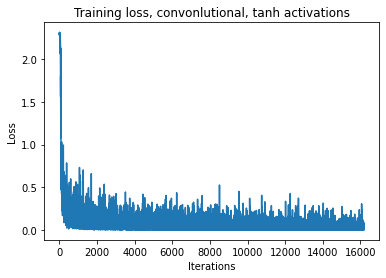

In [ ]:
plt.plot(cost_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training loss, convonlutional, tanh activations')

plt.savefig('T_loss, CONV1_tanh')